In [1]:
from IPython.display import HTML

HTML('''<script>var show_code = true;function toggle(){if(show_code == true){$('div.input').hide();}else{
$('div.input').show();} show_code = !show_code;} $(document).ready(toggle)</script><h4 style="color:lightgray">
<i>Code has been hidden for readability, please click <a href="javascript:toggle()">here</a> to display</h4></i>''')

# Earthquakes Study

A small project that investigates some things about earthquakes using historical data from the USGS.

In [2]:
import os
import sys
import time
import math
import pickle
import string
import scipy as sp
import numpy as np
import pandas as pa
import geopandas as gpa
import matplotlib.pyplot as plt
 
from pandas import DataFrame
import dateutil
from dateutil.parser import parse

from math import *

import jdcal
from jdcal import jcal2jd

import matplotlib.mlab as mlab
import matplotlib.pylab as pylab
from matplotlib.colors import LogNorm, BoundaryNorm, Normalize

pylab.rcParams['figure.figsize'] = (16,9)

## 1 Introduction

Blah blah blah

### 1.1 Preparing The Rebinned Earthquake Data

The data in this project comes from the USGS website (specifically https://earthquake.usgs.gov/data/centennial/ ), 
and in particular the file centennial.cat that contains a large compendium of earthquake data compiled by Engdahl 
and Villasenor.  In doing this study I've discarded several columns that weren't relevant for what I was doing and
converted the file to a somewhat more terse csv file.  The resulting csv file consists of columns of the form:

    #year,month,day,hour,min,sec,lat,lon,dep,frac,jnk,mag,note

The reader is advised that I have discarded a dozen or so columns to the right of these.  So now we embark on cleaning up the data to work with.  We will ultimately be creating a pickle archive containing the prepared data, so let's first check to see if the cleaned archive has already been prepared -- if NOT then we prepare it...

In [3]:
if (os.path.exists('data/usgs.pkl') == True):
    print("earthquakes: found pre-existing data/usgs.pkl file. loading same...")
    usgs = pickle.load(open('data/usgs.pkl','rb'))
else:
    if (os.path.exists('data/centennial.csv') == False):
        raise OSError("earthquakes: can't find data/centennial.csv")
    else:
        centennial = pa.read_csv('data/centennial.csv',
                                 usecols=['year','month','day','hour','min','sec','lat','lon','dep','mag'],
                                 encoding='latin-1')

    # convert the existing time information into modified julian date...
    timestamp = []
    nq = len(centennial)
    for i in range(0,nq):
        row = list(centennial.values[i])
        [y,m,d,H,M,S,lat,lon,dep,mag] = row
        mje,mjd = jcal2jd(y,m,d)
        mjd += (3600.0*H+60*M+S)/86400.0
        timestamp.append(float(mjd))
        
    # insert the mjdate value, drop the other time related ones, reorder...
    centennial.insert(len(row), 'mjdate', pa.Series(data=timestamp, dtype='float32'))
    centennial.drop('year', axis=1, inplace=True)
    centennial.drop('month', axis=1, inplace=True)
    centennial.drop('day', axis=1, inplace=True)
    centennial.drop('hour', axis=1, inplace=True)
    centennial.drop('min', axis=1, inplace=True)
    centennial.drop('sec', axis=1, inplace=True)
    usgs = centennial[list(['mjdate','lon','lat','dep','mag'])]
    pickle.dump(usgs, open('data/usgs.pkl','wb'))
    print("earthquakes: created data/usgs.pkl")

print("earthquakes: usgs has columns %s" % list(usgs.columns))

earthquakes: found pre-existing data/usgs.pkl file. loading same...
earthquakes: usgs has columns ['mjdate', 'lon', 'lat', 'dep', 'mag']


So the first thing we want to do is _bin_ the data.  At first blush one might be tempted to pick something like 
1 deg lon. x 1 deg lat. bins.  But if we do this we end up with an _extremely_ coarse model (10,000 km^2 per cell) and that's not terribly satisfying.  Instead we'll try for something quite a bit finer -- 0.1 deg x 0.1 deg.  That leaves up with ~100 km^2 cells. 

In [4]:
if (os.path.exists('data/binned_usgs.pkl') == True):
    print("earthquake: loading existing data/binned_usgs.pkl")
    binned_data = pickle.load(open('data/binned_usgs.pkl','rb'))
else:
    # so force things into 3600 longitude and 1800 latitude bins
    n = len(usgs) # how many samples do we have?
    for i in range(n):
        lon = usgs['lon'].values[i]
        if (lon > 0):
            usgs['lon'].values[i] = floor(lon)
        else:
            usgs['lon'].values[i] = 360.0 + ceil(lon)
        lat = usgs['lat'].values[i]
        if (lat > 0):
            usgs['lat'].values[i] = floor(lat)
        else:
            usgs['lat'].values[i] = ceil(lat)
    # save out the results as binned_usgs..
    print("earthquake: created and saved data/binned_usgs.pkl")
    pickle.dump(usgs, open('data/binned_usgs.pkl','wb'))
    binned_data = pickle.load(open('data/binned_usgs.pkl','rb'))

earthquake: loading existing data/binned_usgs.pkl


### 1.2 Frequency of Earthquakes vs. Time

This is a curious plot showing the frequency of earthquakes vs. time.  It is likely that the change in
frequency is _not_ related to increased geologic activity so much as from larger numbers of observing 
stations beginning in the period after World War II.  There is a similar abrupt increase -- at almost 
exactly the same dates -- in the _depth_ of earthquakes detected.  This supports the notion that a 
technological change in the instrumentation affected the data.

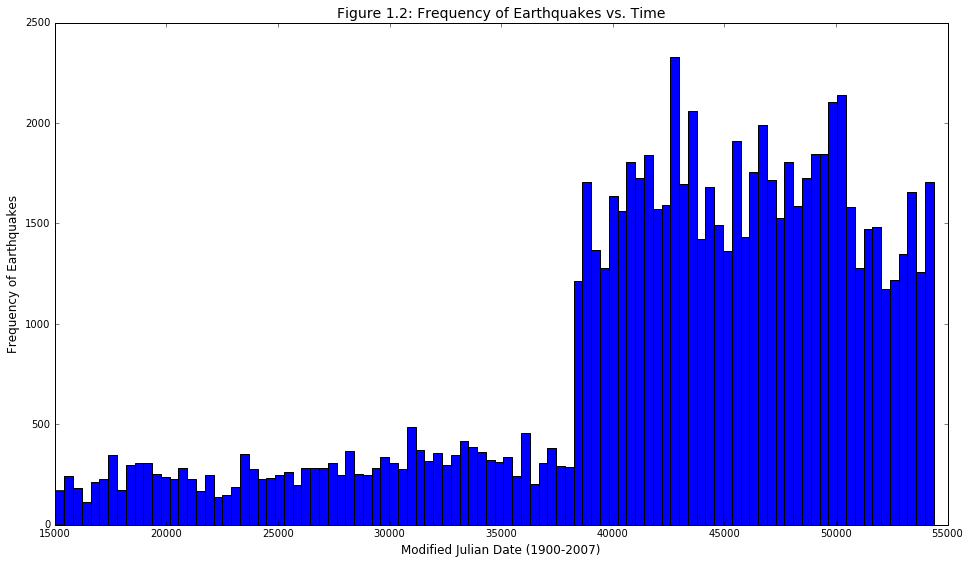

In [5]:
## curious plot showing frequency of earthquakes vs. time...
x1 = binned_data['mjdate']
y1 = binned_data['mag']
#fig = plt.figure(figsize=(16,9))
plt.hist(x1,bins=100,weights=y1)
plt.title('Figure 1.2: Frequency of Earthquakes vs. Time',size=14)
plt.ylabel('Frequency of Earthquakes',size=12)
plt.xlabel('Modified Julian Date (1900-2007)',size=12)
plt.show()
plt.savefig('images/fig1p2.png')
plt.close()

### 1.3 Locations of Earthquakes

This figure shows a 2-d histogram (viewed from above) for the location of earthquakes on 
the surface of the earth. 

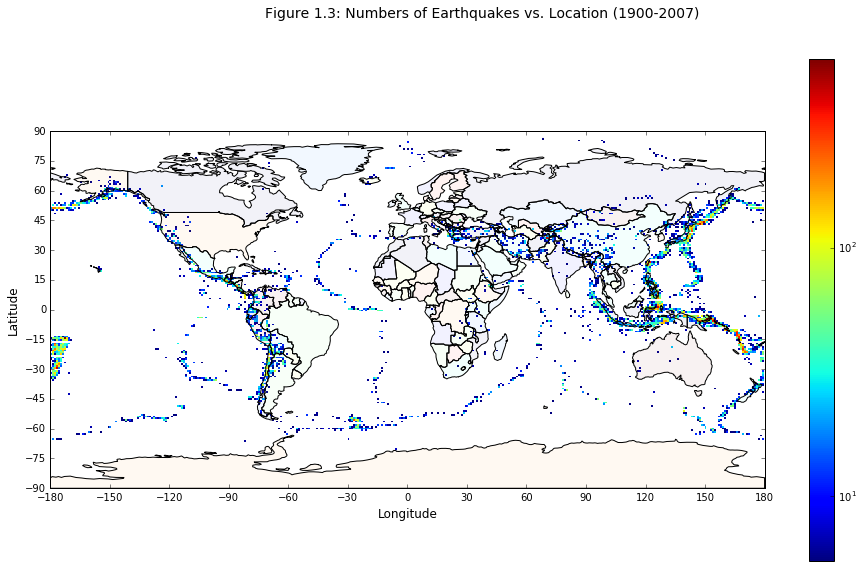

In [6]:
## latitude-longitude vs magnitude of earthquakes
x2 = []
values = binned_data['lon'].values
for i in range(0,len(values)):
    this_x = values[i]
    if ((this_x >= 0) and (this_x < 180.0)):
        x2.append(this_x)
    else:
        x2.append(this_x - 360.0)
y2 = binned_data['lat']
c2 = binned_data['mag']
#fig2 = plt.figure(figsize=(16,9))
world = gpa.read_file(gpa.datasets.get_path('naturalearth_lowres'))
world.plot(alpha=0.05)
#plt.axis('scaled')
plt.hist2d(x2,y2,bins=(360,180),weights=c2, norm=LogNorm())
plt.suptitle('Figure 1.3: Numbers of Earthquakes vs. Location (1900-2007)',size=14)
plt.ylabel('Latitude',size=12)
plt.xlabel('Longitude',size=12)
plt.xticks([-180,-150,-120,-90,-60,-30,0,30,60,90,120,150,180])
plt.yticks([-90,-75,-60,-45,-30,-15,0,15,30,45,60,75,90])
plt.colorbar()
plt.show()
plt.savefig('images/fig1p3.png')
plt.close()

### 1.4 Number Distribution of Earthquakes of Various Magnitudes

This figure shows a histogram for how often earthquakes of various sizes occur.

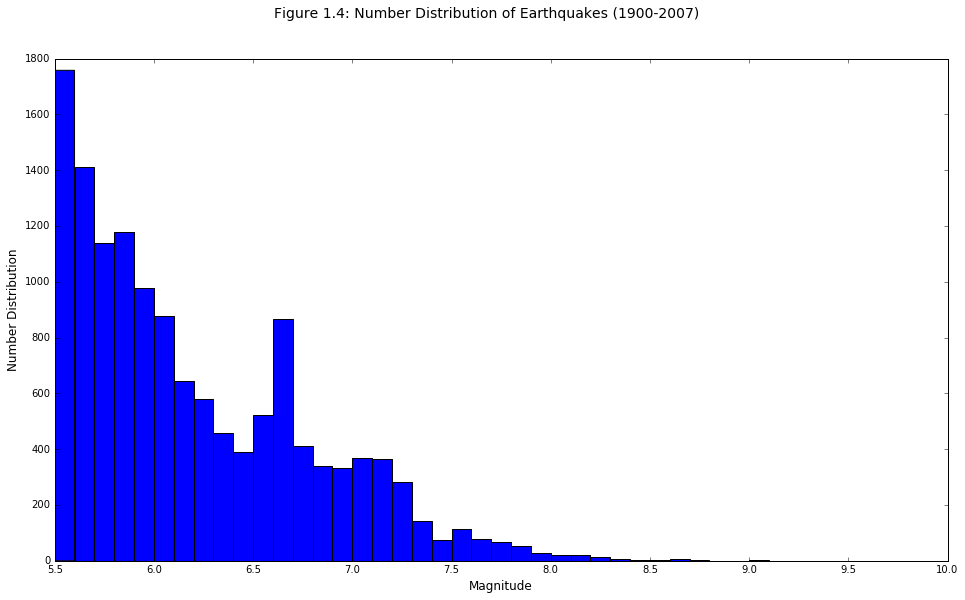

In [7]:
## frequency vs. magnitude...
c2max = max(c2)
c2min = min(c2)
#fig3 = plt.figure(figsize=(16,9))
plt.hist(y1,bins=int((c2max-c2min)*10))
plt.suptitle('Figure 1.4: Number Distribution of Earthquakes (1900-2007)',size=14)
plt.ylabel('Number Distribution',size=12)
plt.xlabel('Magnitude',size=12)
plt.show()
plt.savefig('images/fig1p4.png')
plt.close()

## 2 Modeling

So we have descriptive data that showing that an earthquake of magnitude R occurred @ (lon, lat, dep, t).  The 
question then is whether we can develop a useful predictive model that would allow us to estimate risks and 
likelihoods for future earthquakes @ (lon, lat, dep, t).

There are a total of 10792 earthquakes on 8399 different days scattered across 100 years.  If we divide the surface 
of the earth up into 1 deg x 1 deg cells, then all of the earthquakes occurred in only 424 distinct (lon,lat) 
locations.  This means that of the 64,800 possible cells only 0.65% of them have had earthquakes in the past century.

### 2.1 Discussion

If we had not seen Figure 1.3, it might be tempting to start off with an initial assumption that earthquakes are 
uncorrelated and an earth quake in one cell would be terribly unlikely to affect the likelihood of another cell
experiencing an earthquake.  Unfortunately it is very clear that there is a dramatic tendency for earthquakes to 
cluster.  

This suggests that it might be appropriate to consider an approach that is cogniscent of the geometrical
relationships among the cells.  One might approach this in several ways -- one would be to consider the 
location of the cells on the surface of the earth -- a two dimensional association map as it were;  another would be
to consider the location of the cells on the full three dimensional earth -- a three dimensional association map.

If for example there turns out to be a meaningful correlation between earthquakes happening at key locations 
on the 3 dimensional earth on the same day (or neighboring days) then it might make sense to use the full 3d
model.  These locations might be at the exact opposite side of the earth from the epicenter of a particular
quake -- or perhaps at 60 deg, 90 deg, 120 deg intervals around a great circle connecting the epicenter with
the antipodal epicenter.  If such correlations do NOT exist, then the 2d model ought to be sufficient.

#### 2.1.1 Searching for SpatioTemporal Correlations Among Earthquakes